In [1]:
import numpy as np
from skimage.measure import block_reduce
from skimage.transform import radon, iradon
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
import PIL
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import skimage.transform as trans
import numpy as np
from torch.nn import init
import random
import os
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.stats import iqr

In [2]:
import pydicom as dicom
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cv2
import skimage as skimage
from skimage.measure import label 
import math
import pandas as pd
import scipy.io
import nibabel as nb

In [3]:
class ToTensor(object):
    def __call__(self, sample):
        t1, t2, t1m, bladder_mask = sample['t1'], sample['t2'], sample['t1m'], sample['bladder_mask']
        t1 = t1.astype('float64')  
        t2 = t2.astype('float64')  
        t1m = t1m.astype('float64') 
        bladder_mask = bladder_mask.astype('float64')
        
        
        return {'t1': torch.from_numpy(t1),
                't2': torch.from_numpy(t2),
                't1m': torch.from_numpy(t1m),
                'bladder_mask': torch.from_numpy(bladder_mask)
                
               }

# Define Blocks in Net

In [4]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x
    
class resconv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(resconv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        
        residual =  self.Conv_1x1(x)
        x = self.conv(x)
        
        #print(residual.size())
        #print(x.size())
        
        return residual+x
    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    

# Define Nets

In [5]:
class U_Net(nn.Module):
    def __init__(self,ngpu,img_ch=2,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
   
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
   

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)
       

        # decoding + concat path

        
        d4 = self.Up4(x4)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1
    


# Define Net Weights Initialization

In [6]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

# Function - delete th files in a folder

In [7]:
def del_file(path):
    ls = os.listdir(path)
    for i in ls:
        c_path = os.path.join(path, i)
        if os.path.isdir(c_path):
            del_file(c_path)
        else:
            os.remove(c_path)

# 1. Datapath Defination for Train, Validataion and Test: Train_, Val_, Test_.

In [8]:
TrainDataDir = '/mnt/LiDXXLab_Files/Haoran/prostate_QM/training_dataset_3/elastic_resized/'
ls = os.listdir(TrainDataDir)
print(ls)
print(len(ls))

['sub0125', 'sub0408', 'sub0419', 'sub0513', 'sub1006', 'sub0211', 'sub1216', 'sub05201', 'sub1201', 'sub0901', 'sub0608', 'sub0106', 'sub05202', 'sub0519', 'sub0427', 'sub0517', 'sub0413', 'sub0624', 'sub1117', 'sub0930', 'sub0526', 'sub0415', 'sub0316', 'bladder_mask_t2m', 'sub0207', 'sub0518', 'sub0527', 'sub0412']
28


In [9]:
ls = ['sub0125', 'sub0408', 'sub0419', 'sub0513', 'sub1006', 'sub0211', 'sub1216', 'sub1201', 'sub0901', 'sub0608', 'sub0106',  'sub0519', 'sub0427', 'sub0517', 'sub0413', 'sub0624', 'sub1117', 'sub0930', 'sub0526', 'sub0415', 'sub0316',  'sub0207', 'sub0518', 'sub0527', 'sub0412']

## split the subject idex to three groups.
Total subjects = 20

Train : Validation : Testing = 14 : 3 : 3

In [10]:
## project has air : 0517,0526,
## project moving a lot : 05202


split_number = 1
train_idex = ['sub0519', 'sub0419', 'sub1201', 'sub0930', 'sub0527', 'sub0412', 'sub0608', 'sub1006', 'sub0125', 'sub0211', 'sub0207', 'sub0316', 'sub0513', 'sub0624', 'sub0427', 'sub0901', 'sub0408', 'sub0415', 'sub0518']

testing_idex = ['sub1216', 'sub0413','sub1117','sub0106']

validation_idex = ['sub0517','sub0526']



split_number = 2
train_idex = ['sub0519', 'sub0106', 'sub0419', 'sub1201', 'sub0930', 'sub0527', 'sub0412', 'sub0413', 'sub0608', 'sub1117', 'sub1006', 'sub0125', 'sub0207', 'sub1216', 'sub0513', 'sub0624', 'sub0408', 'sub0415', 'sub0518']

testing_idex = ['sub0427','sub0211','sub0901','sub0316']

validation_idex = ['sub0517','sub0526']


split_number = 3
train_idex = ['sub0519', 'sub0106', 'sub1201', 'sub0930', 'sub0527', 'sub0412', 'sub0413', 'sub0608', 'sub1117', 'sub0125', 'sub0211', 'sub0207', 'sub1216', 'sub0316', 'sub0513', 'sub0427', 'sub0901', 'sub0408', 'sub0518']

testing_idex = ['sub0419','sub1006','sub0415','sub0624']

validation_idex = ['sub0517','sub0526']



split_number = 4
train_idex = ['sub0519', 'sub0106', 'sub0419', 'sub0527', 'sub0412', 'sub0413', 'sub1117', 'sub1006', 'sub0211', 'sub1216', 'sub0316', 'sub0513', 'sub0624', 'sub0427', 'sub0901', 'sub0408', 'sub0415', 'sub0518']

testing_idex = ['sub1201','sub0207','sub0125','sub0930','sub0608']

validation_idex = ['sub0517','sub0526']



subject_idex = ls
testing_idex = []
validation_idex = []

for subject_elements in subject_idex:
    #print(subject_elements)
    if subject_elements.startswith("sub0901"):
        testing_idex.append(subject_elements)
    if subject_elements.startswith("sub0930"):
        validation_idex.append(subject_elements)
train_idex =   list(set(subject_idex)-set(testing_idex)-set(validation_idex))   



In [11]:
train_dataset_number = len(train_idex)
validation_dataset_number = len(validation_idex)
testing_dataset_number= len(testing_idex)


In [12]:
print(train_dataset_number)
print(validation_dataset_number)
print(testing_dataset_number)


19
2
4


# 2. Dataset Defination for Train, Validataion and Test

In [13]:
# Train Dataset
class MRIDataset(Dataset):
    
    def __init__(self, DataDir,ImgPrefix,transform=None):
        print('***************')
        print('MRIDataset')
        imgprefix = ImgPrefix[0]
        print(ImgPrefix)
        print('---------------')
                       
        AllT1 = []
        AllT2 = []
        AllT1map = []
        AllMaskbladder = []
        AllMasktissue = []
        
        T1Img = nb.load(DataDir+imgprefix+'/t1_elastic_resized.nii')
        T2Img = nb.load(DataDir+imgprefix+'/t2_elastic_resized.nii')
        T1mapImg = nb.load(DataDir+imgprefix+'/t2m_fitted_elastic_resized.nii')
        AllMask_bladder = nb.load(DataDir+'bladder_mask_t2m/'+imgprefix+'_bladder_mask_t2m.nii')
        #AllMask_tissue = nb.load(DataDir+'elastic_resize_tissuemask/'+imgprefix+'_tissue_outline.nii')
        
        AllT1 = T1Img.get_fdata()
        AllT2 = T2Img.get_fdata()
        AllT1map = T1mapImg.get_fdata()
        AllMaskbladder = AllMask_bladder.get_fdata()
        #AllMasktissue = AllMask_tissue.get_fdata()
        
        AllMaskbladder_idex = np.asarray(AllMaskbladder)
                
        T1_norm = np.asarray(AllT1[AllMaskbladder_idex >=1]).mean()+3*np.std(AllT1[AllMaskbladder_idex >=1]).astype(np.float32)
        T2_norm = np.asarray(AllT2[AllMaskbladder_idex >=1]).mean()+3*np.std(AllT2[AllMaskbladder_idex >=1]).astype(np.float32)
        T1m_norm = 400
        
        print(T1_norm)
        print(T2_norm)
        
        AllT1 = AllT1/T1_norm
        AllT2 = AllT2/T2_norm
        AllT1map = AllT1map/T1m_norm
        
        
        print(imgprefix+' loaded...')
        print(np.shape(AllT1))
        print(np.shape(AllT2))
        print(np.shape(AllT1map))
        
        for imgprefix in ImgPrefix[1:len(ImgPrefix)]:
            
            T1Img = nb.load(DataDir+imgprefix+'/t1_elastic_resized.nii')
            T2Img = nb.load(DataDir+imgprefix+'/t2_elastic_resized.nii')
            T1mapImg = nb.load(DataDir+imgprefix+'/t2m_fitted_elastic_resized.nii')
            MaskImg_bladder = nb.load(DataDir+'bladder_mask_t2m/'+imgprefix+'_bladder_mask_t2m.nii')
            #MaskImg_tissue = nb.load(DataDir+'elastic_resize_tissuemask/'+imgprefix+'_tissue_outline.nii')
            
            
            T1Data = T1Img.get_fdata()
            T2Data = T2Img.get_fdata()
            T1mapData = T1mapImg.get_fdata()
            MaskData_bladder = MaskImg_bladder.get_fdata()
            #MaskData_tissue = MaskImg_tissue.get_fdata()
            
            MaskData_bladder_index = np.asarray(MaskData_bladder)
            
            T1_norm = np.asarray(T1Data[MaskData_bladder_index >=1]).mean()+3*np.std(T1Data[MaskData_bladder_index >=1]).astype(np.float32)
            T2_norm = np.asarray(T2Data[MaskData_bladder_index >=1]).mean()+3*np.std(T2Data[MaskData_bladder_index >=1]).astype(np.float32)
            T1m_norm = 400
            
            T1Data = T1Data/T1_norm
            T2Data = T2Data/T2_norm
            T1mapData = T1mapData/T1m_norm
            
            print(imgprefix+' loaded...')
           
            AllT1 = np.concatenate((AllT1, T1Data), axis=2)
            AllT2 = np.concatenate((AllT2, T2Data), axis=2)
            AllT1map = np.concatenate((AllT1map, T1mapData), axis=2)
            AllMaskbladder = np.concatenate((AllMaskbladder, MaskData_bladder), axis=2)
            #AllMasktissue = np.concatenate((AllMasktissue, MaskData_tissue), axis=2)

        
        AllT1 = np.transpose(AllT1, (2, 0, 1))
        AllT2 = np.transpose(AllT2, (2, 0, 1))
        AllT1map = np.transpose(AllT1map, (2, 0, 1))
        AllMaskbladder = np.transpose(AllMaskbladder, (2, 0, 1))
        #AllMasktissue = np.transpose(AllMasktissue, (2, 0, 1))

        print('Total MRIDataset size is: ' + str(np.shape(AllT1)))
        print('Total MRIDataset size is: ' + str(np.shape(AllMaskbladder)))
        #print('Total MRIDataset size is: ' + str(np.shape(AllMasktissue)))
        
        self.transform = transform
        self.AllT1 = AllT1
        self.AllT2 = AllT2
        self.AllT1map = AllT1map
        self.AllMaskbladder = AllMaskbladder
        #self.AllMasktissue = AllMasktissue
    
    def __len__(self):
        return len(self.AllT1)
    
    def __getitem__(self, idx):
        
        
        sample = {'t1': np.array(self.AllT1[idx]),
                  't2': np.array(self.AllT2[idx]),
                  't1m': np.array(self.AllT1map[idx]),
                  'bladder_mask': np.array(self.AllMaskbladder[idx])
                  #'tissue_mask': np.array(self.AllMasktissue[idx]) 
                  }

        if self.transform:
            sample = self.transform(sample)

        return sample



# 3. Dataloader for train, validation and test

In [14]:
# Train
Train_MRIDataset = MRIDataset(DataDir=TrainDataDir,ImgPrefix=train_idex,
                        transform=transforms.Compose([ToTensor()]))
Train_dataloader = DataLoader(Train_MRIDataset, batch_size=4,
                       shuffle=True, num_workers=4)

***************
MRIDataset
['sub0519', 'sub0419', 'sub1201', 'sub0930', 'sub0527', 'sub0412', 'sub0608', 'sub1006', 'sub0125', 'sub0211', 'sub0207', 'sub0316', 'sub0513', 'sub0624', 'sub0427', 'sub0901', 'sub0408', 'sub0415', 'sub0518']
---------------
424.8102265959266
518.9125459017894
sub0519 loaded...
(224, 112, 24)
(224, 112, 24)
(224, 112, 24)
sub0419 loaded...
sub1201 loaded...
sub0930 loaded...
sub0527 loaded...
sub0412 loaded...
sub0608 loaded...
sub1006 loaded...
sub0125 loaded...
sub0211 loaded...
sub0207 loaded...
sub0316 loaded...
sub0513 loaded...
sub0624 loaded...
sub0427 loaded...
sub0901 loaded...
sub0408 loaded...
sub0415 loaded...
sub0518 loaded...
Total MRIDataset size is: (456, 224, 112)
Total MRIDataset size is: (456, 224, 112)


In [15]:
# Validation
Validation_MRIDataset = MRIDataset(DataDir=TrainDataDir,ImgPrefix=validation_idex,
                                 transform=transforms.Compose([ToTensor()]))
Val_dataloader = DataLoader(Validation_MRIDataset, batch_size=4,
                       shuffle=True, num_workers=4)

***************
MRIDataset
['sub0517', 'sub0526']
---------------
425.20323610150933
599.1260747463963
sub0517 loaded...
(224, 112, 24)
(224, 112, 24)
(224, 112, 24)
sub0526 loaded...
Total MRIDataset size is: (48, 224, 112)
Total MRIDataset size is: (48, 224, 112)


# Test
Test_MRIDataset = MRIDataset(DataDir=TrainDataDir,ImgPrefix=testing_idex,
                                  transform=transforms.Compose([ToTensor()]))
Test_dataloader = DataLoader(Test_MRIDataset, batch_size=1,
                             shuffle=False, num_workers=1)

# 4. GPU setup. (add multiple GPU code...)

In [16]:
# GPU Setup for Trainning and Validation
ngpu = 2
TEST = 0
num_epochs = 120
lr = 1e-3 # lr: learning rate, can try big to small
beta1 = 0.9
print(torch.cuda.is_available())
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

True
cuda:0


# 5. Net Selection and Initialization

In [17]:
# Net Selection
U_Net = U_Net(ngpu).to(device)

# Net Initialization
if TEST:
    U_Net.load_state_dict(torch.load(Setting+'/BackProjector.pt'))
    U_Net.eval()
else:
    U_Net.apply(init_weights)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initiali

# 6. Optimization Method Selection (i.e., loss function, regularization function, strategy) 

In [18]:
criterion = nn.L1Loss()
optimizerUnet = optim.Adam(U_Net.parameters(), lr=lr, betas=(beta1, 0.999))

# 7. Trainng and Validation: save the Train_Loss, Val_Loss and save the Model_Best and Model_Last.

In [19]:
now = datetime.now()
date = now.strftime("%Y%m%d")
print("date and time:",date)

ModelPath_Best = '/mnt/LiDXXLab_Files/Haoran/prostate_QM/trianing_model/sub_25_cv/t2m_fitted/Best_model/Unet_mean3stdnorm_exblader'+'_'+date

ModelPath_Last = '/mnt/LiDXXLab_Files/Haoran/prostate_QM/trianing_model/sub_25_cv/t2m_fitted/Last_model/Unet_mean3stdnorm_exblader'+'_'+date

ModelPath_Inter = '/mnt/LiDXXLab_Files/Haoran/prostate_QM/trianing_model/sub_25_cv/t2m_fitted/Inter_model/Unet_mean3stdnorm_exblader'+'_'+date

os.makedirs(ModelPath_Best, exist_ok = True)
os.makedirs(ModelPath_Last, exist_ok = True)
os.makedirs(ModelPath_Inter, exist_ok = True)

date and time: 20221212


In [20]:
Err_train_avg_before=1000;
Err_val_avg_before=1000;

Err_train_avg_list = []
Err_val_avg_list = []

for epoch in range(num_epochs):
    # Training
    Err_train_total = 0
    Err_val_total = 0
    Err_train_avg = 0
    Err_val_avg = 0 

    Train_iter=0
    U_Net.train()
    for i, data in enumerate(Train_dataloader, 0):
        
        t1 = data['t1'].to(device, dtype=torch.float).requires_grad_()
        t2 = data['t2'].to(device, dtype=torch.float).requires_grad_()
        t1m = data['t1m'].to(device, dtype=torch.float).requires_grad_()
        bladder_mask = data['bladder_mask'].to(device, dtype=torch.float).requires_grad_()
       
        
        
        bladder_mask_idex = bladder_mask.cpu().detach().numpy()
       
        
        t1m_idex = t1m.cpu().detach().numpy()
        t1m_mask = t1m_idex.copy()
        t1m_mask[t1m_idex>1]=0
        t1m_mask[t1m_idex<=1]=1
           
       
        bladder_mask_invert = bladder_mask_idex.copy()
        bladder_mask_invert = np.abs(bladder_mask_invert-1)
    
        mask_loss = bladder_mask_invert*t1m_mask
        mask_loss = torch.tensor(mask_loss)
       
    
        Prediction = torch.squeeze(U_Net(torch.stack([t1, t2], dim=1)))
        
        del t1,t2
        
        Prediction_vector = Prediction[mask_loss == 1]
        del Prediction
        
        Target_vector = t1m[mask_loss == 1]
        del t1m, mask_loss
        
        optimizerUnet.zero_grad()
        Err_train = criterion(Prediction_vector, Target_vector)
        Err_train.backward()#backward
        optimizerUnet.step()#forward

        #if i % 50 == 0:
        #    print('Err_train')
        #    print(Err_train.item())
            
        Err_train_total += Err_train.item()
        Train_iter += 1 
        
    Err_train_avg=Err_train_total/train_dataset_number # Haoran please change here
    Err_train_avg_list.append(Err_train_avg)
    
    # Validation
    Val_iter=0
    
    U_Net.eval()
    for i, data in enumerate(Val_dataloader, 0):
        
        t1 = data['t1'].to(device, dtype=torch.float).requires_grad_()
        t2 = data['t2'].to(device, dtype=torch.float).requires_grad_()
        t1m = data['t1m'].to(device, dtype=torch.float).requires_grad_()
        bladder_mask = data['bladder_mask'].to(device, dtype=torch.float).requires_grad_()
       
        
        
        bladder_mask_idex = bladder_mask.cpu().detach().numpy()
        
        
        
        t1m_idex = t1m.cpu().detach().numpy()
        t1m_mask = t1m_idex.copy()
        t1m_mask[t1m_idex>1]=0
        t1m_mask[t1m_idex<=1]=1
       
        
        bladder_mask_invert = bladder_mask_idex.copy()
        bladder_mask_invert = np.abs(bladder_mask_invert-1)
    
        mask_loss = bladder_mask_invert*t1m_mask
        mask_loss = torch.tensor(mask_loss)
        
        Prediction = torch.squeeze(U_Net(torch.stack([t1, t2], dim=1)))
        del t1,t2
        
        Prediction_vector = Prediction[mask_loss == 1]
        del Prediction
        
        Target_vector = t1m[mask_loss == 1]
        del t1m,  mask_loss
        
        Err_val = criterion(Prediction_vector, Target_vector)
        
        #if i % 10 == 0:
        #    print('Err_val')
        #    print(Err_val.item())
            
        Err_val_total += Err_val.item()
        Val_iter += 1 
        
    Err_val_avg=Err_val_total/validation_dataset_number 
    Err_val_avg_list.append(Err_val_avg)
    
    U_Net.train()
    
    ## Save the best
    # check if Err_train decreases and if Err_val decreases
    if Err_train_avg < Err_train_avg_before and Err_val_avg < Err_val_avg_before:
        del_file(ModelPath_Best)
        torch.save(U_Net.state_dict(), ModelPath_Best+'/sub_25_Unet_CVsplit'+str(split_number)+'_epoch'+str(epoch)+'_'+date+'.pt')
        model_best_epoch = epoch
        Err_train_avg_before = Err_train_avg
        Err_val_avg_before = Err_val_avg
        print('[%d/%d]\t Err_val_before: %.10f\t'
              % (epoch, num_epochs, Err_val_avg_before))

    if epoch % 5 == 0:
        print('[%d/%d]\t Err_train_avg: %.10f\t Err_val_avg: %.10f\t'
              % (epoch, num_epochs, Err_train_avg,Err_val_avg))
        
        
    if epoch % 10 == 0 and epoch > 20:
        torch.save(U_Net.state_dict(), ModelPath_Inter+'/sub_25_Unet_CVsplit'+str(split_number)+'_epoch'+str(epoch)+'_'+date+'.pt')
        
# save the Model_Last
torch.save(U_Net.state_dict(), ModelPath_Last+'/sub_25_Unet_CVsplit'+str(split_number)+'_epoch'+str(epoch)+'_'+date+'.pt')


[0/120]	 Err_val_before: 0.2669194974	
[0/120]	 Err_train_avg: 0.2738141623	 Err_val_avg: 0.2669194974	
[3/120]	 Err_val_before: 0.2613135595	
[5/120]	 Err_val_before: 0.2612282559	
[5/120]	 Err_train_avg: 0.1969774569	 Err_val_avg: 0.2612282559	
[8/120]	 Err_val_before: 0.2489551697	
[10/120]	 Err_val_before: 0.2461203225	
[10/120]	 Err_train_avg: 0.1870731473	 Err_val_avg: 0.2461203225	
[12/120]	 Err_val_before: 0.2415396180	
[15/120]	 Err_train_avg: 0.1826455196	 Err_val_avg: 0.2469664514	
[19/120]	 Err_val_before: 0.2382066771	
[20/120]	 Err_train_avg: 0.1780403547	 Err_val_avg: 0.2376054265	
[24/120]	 Err_val_before: 0.2344028447	
[25/120]	 Err_val_before: 0.2342026047	
[25/120]	 Err_train_avg: 0.1672360573	 Err_val_avg: 0.2342026047	
[29/120]	 Err_val_before: 0.2321130205	
[30/120]	 Err_train_avg: 0.1586284032	 Err_val_avg: 0.2461577170	
[35/120]	 Err_train_avg: 0.1546686839	 Err_val_avg: 0.2388514411	
[36/120]	 Err_val_before: 0.2316507082	
[40/120]	 Err_train_avg: 0.1532903689	

#  7.2 Plot Train and Validation Errors

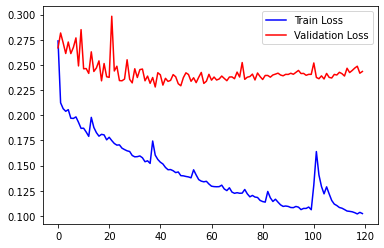

48


In [21]:
# plot errors for all epoches
plt.plot(Err_train_avg_list,'b')
plt.plot(Err_val_avg_list,'r')
plt.legend(['Train Loss','Validation Loss'])
#plt.axis([0, num_epochs, 0, 0.04])
plt.show()
print(model_best_epoch)

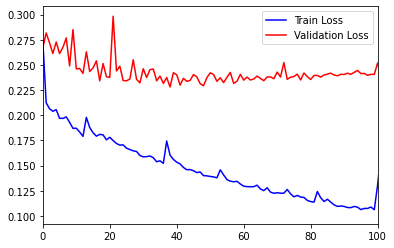

48


In [22]:
# plot errors for all epoches
plt.plot(Err_train_avg_list,'b')
plt.plot(Err_val_avg_list,'r')
plt.legend(['Train Loss','Validation Loss'])
plt.xlim([0, 100])
plt.show()
print(model_best_epoch)